In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
from enum import Enum
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
from time import time
from tqdm import tqdm
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline
set_matplotlib_formats('svg')
!python --version

Python 3.9.2


In [2]:
data = pd.read_csv('results/linear-regression.csv')
data

,Loss,Time,Solver,Subset,p
0,3.977135e+16,0.037496,SGD,Train,2
1,3.982112e+16,0.037496,SGD,Test,2
2,1.622489e+05,0.000261,Analytic,Train,2
3,1.263900e+05,0.000261,Analytic,Test,2
4,7.598583e+23,0.016289,SGD,Train,2
...,...,...,...,...,...
1035,3.630502e+05,20.430621,Analytic,Test,3002
1036,1.661757e+23,1.613384,SGD,Train,3002
1037,1.280116e+23,1.613384,SGD,Test,3002
1038,2.528878e-20,20.357091,Analytic,Train,3002


<AxesSubplot:xlabel='p', ylabel='Time'>

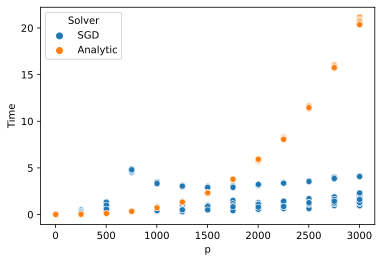

In [3]:
sns.scatterplot(data=data, x='p', y='Time', hue='Solver')

In [4]:
sgd = data[data['Solver'] == 'SGD']
sgd_test  = sgd.sample(frac=0.2)
sgd_train = sgd[~sgd.index.isin(sgd_test.index)]
sgd_train.shape, sgd_test.shape

((416, 5), (104, 5))

In [5]:
ana = data[data['Solver'] == 'Analytic']
ana_test  = ana.sample(frac=0.2)
ana_train = ana[~ana.index.isin(ana_test.index)]
ana_train.shape, ana_test.shape

((416, 5), (104, 5))

In [6]:
data.loc[data.index.isin(sgd_train.index), 'Subset'] = 'Train'
data.loc[data.index.isin(sgd_test.index), 'Subset'] = 'Test'
data.loc[data.index.isin(ana_train.index), 'Subset'] = 'Train'
data.loc[data.index.isin(ana_test.index), 'Subset'] = 'Test'
data['Subset'].value_counts()

Train    832
Test     208
Name: Subset, dtype: int64

In [7]:
def polynomial_design_matrix(df, degree):
    poly = PolynomialFeatures(degree=degree)

    X = df[['p']].values
    X = poly.fit_transform(X)
    Y = df[['Time']].values

    return X, Y

Xsgd_train, Ysgd_train = polynomial_design_matrix(sgd_train, 5)
Xsgd_test, Ysgd_test = polynomial_design_matrix(sgd_test, 5)
Xsgd_train.shape, Ysgd_train.shape

((416, 6), (416, 1))

In [8]:
β = lambda X, Y: np.linalg.pinv(X.T @ X) @ X.T @ Y
βsgd = β(Xsgd_train, Ysgd_train)
βsgd

array([[ 4.58491659e-26],
       [ 7.94727874e-23],
       [ 1.42116022e-19],
       [ 2.28798790e-16],
       [ 2.83986690e-13],
       [-8.89056129e-17]])

In [9]:
def interpolated_predict(degree, x_left_lim, x_right_lim, βhat, solver):
    poly = PolynomialFeatures(degree=degree)

    x = np.linspace(x_left_lim, x_right_lim)
    X = np.expand_dims(x, axis=1)
    X = poly.fit_transform(X)

    Ŷ = X @ βhat

    res = pd.DataFrame({'x': x, 'y': Ŷ.flatten(), 'Solver': solver})

    return res

interpolated_predict(5, 0, 4000, βsgd, 'SGD').head()

,x,y,Solver
0,0.000000,4.584917e-26,SGD
1,81.632653,1.228895e-05,SGD
2,163.265306,1.914656e-04,SGD
3,244.897959,9.431872e-04,SGD
4,326.530612,2.898428e-03,SGD


In [10]:
MSE = lambda X, Y, β: (np.transpose(Y - X @ β) @ (Y - X @ β) / len(X)).item()

def err_subsets(X_train, Y_train, X_test, Y_test, β):
    err_train = MSE(X_train, Y_train, β)
    err_test =  MSE(X_test, Y_test, β)
    return err_train, err_test

err_subsets(Xsgd_train, Ysgd_train, Xsgd_test, Ysgd_test, βsgd)

(2.404805786985933, 2.961259756232595)

In [11]:
def errors_of_degree(degree):
    Xsgd_train, Ysgd_train = polynomial_design_matrix(sgd_train, degree=degree)
    Xsgd_test, Ysgd_test = polynomial_design_matrix(sgd_test, degree=degree)
    data = Xsgd_train, Ysgd_train, Xsgd_test, Ysgd_test
    MSEsgd_train, MSEsgd_test = err_subsets(*data, βsgd)

    Xana, Yana = polynomial_design_matrix(ana_train, degree=degree)

In [12]:
def predictions_of_degree(degree):
    Xsgd_train, Ysgd_train = polynomial_design_matrix(sgd_train, degree=degree)
    Xana_train, Yana_train = polynomial_design_matrix(ana_train, degree=degree)
    βsgd = β(Xsgd_train, Ysgd_train)
    βana = β(Xana_train, Yana_train)
    
    res1 = interpolated_predict(degree, data['p'].min(), 4000, βsgd, 'SGD')
    res2 = interpolated_predict(degree, data['p'].min(), 4000, βana, 'Analytic')
    res = pd.concat([res1, res2])
    res['degree'] = degree

    Xsgd_train, Ysgd_train = polynomial_design_matrix(sgd_train, degree=degree)
    Xsgd_test, Ysgd_test = polynomial_design_matrix(sgd_test, degree=degree)
    sets = Xsgd_train, Ysgd_train, Xsgd_test, Ysgd_test
    MSEsgd = err_subsets(*sets, βsgd)

    Xana_train, Yana_train = polynomial_design_matrix(ana_train, degree=degree)
    Xana_test, Yana_test = polynomial_design_matrix(ana_test, degree=degree)
    sets = Xana_train, Yana_train, Xana_test, Yana_test
    MSEana = err_subsets(*sets, βana)

    return res, MSEsgd, MSEana

res, MSEsgd, MSEana = predictions_of_degree(5)
res

,x,y,Solver,degree
0,2.000000,4.542773e-12,SGD,5
1,83.591837,1.350334e-05,SGD,5
2,165.183673,2.004973e-04,SGD,5
3,246.775510,9.718269e-04,SGD,5
4,328.367347,2.962296e-03,SGD,5
...,...,...,...,...
45,3673.632653,3.392597e+01,Analytic,5
46,3755.224490,3.544746e+01,Analytic,5
47,3836.816327,3.689249e+01,Analytic,5
48,3918.408163,3.824201e+01,Analytic,5


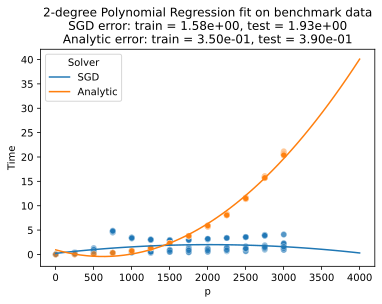

In [13]:
def plot_degree(degree):
    res, MSEsgd, MSEana = predictions_of_degree(degree)
    sns.scatterplot(data=data, x='p', y='Time', alpha=0.3, hue='Solver',
        legend=False)
    sns.lineplot(data=res, x='x', y='y', hue='Solver')
    plt.title(f'{degree}-degree Polynomial Regression fit on benchmark data' +
        f'\nSGD error: train = {MSEsgd[0]:.2e}, test = {MSEsgd[1]:.2e}' +
        f'\nAnalytic error: train = {MSEana[0]:.2e}, test = {MSEana[1]:.2e}')
plot_degree(2)

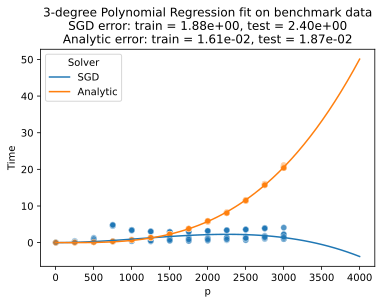

In [14]:
plot_degree(3)

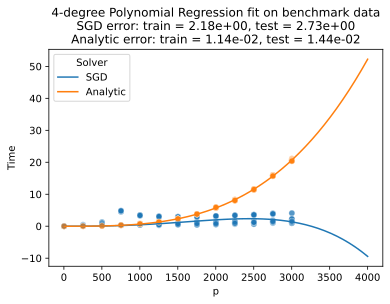

In [15]:
plot_degree(4)

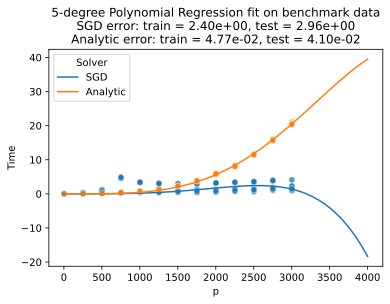

In [16]:
plot_degree(5)

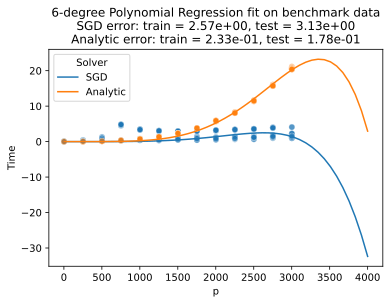

In [17]:
plot_degree(6)